# Fine Tuning

In [1]:
%matplotlib inline
import d2l
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import os
import zipfile

## Hot Dog Recognition Dataset


### Download the Data Set

In [2]:
data_dir = '.'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname = gutils.download(
    base_url + 'gluon/dataset/hotdog.zip',
    path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
with zipfile.ZipFile(fname, 'r') as z:
    z.extractall(data_dir)
!tree -d hotdog

hotdog
├── test
│   ├── hotdog
│   └── not-hotdog
└── train
    ├── hotdog
    └── not-hotdog

6 directories


### Read the Dataset 

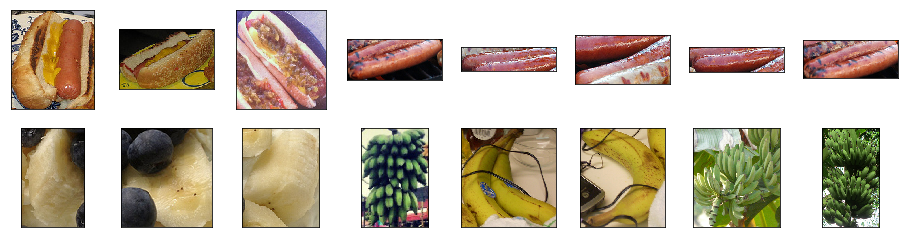

In [3]:
train_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/train'))
test_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/test'))

hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=2);

### Image Augmentation 

In [4]:
# We specify the mean and variance of the three RGB channels to normalize the image channel.
normalize = gdata.vision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomResizedCrop(224),
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor(),
    normalize])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.Resize(256),
    gdata.vision.transforms.CenterCrop(224),
    gdata.vision.transforms.ToTensor(),
    normalize])

## Model 

### Download Pre-trained Models

In [5]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.output

Dense(512 -> 1000, linear)

### Initialize Model for Fine Tuning 

In [6]:
finetune_net = model_zoo.vision.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# The model parameters in output will be updated using a learning rate ten times greater.
finetune_net.output.collect_params().setattr('lr_mult', 10)

## Fine Tune

In [7]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gdata.DataLoader(
        train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gdata.DataLoader(
        test_imgs.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': 0.001})
    d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

### Train

In [8]:
train_fine_tuning(finetune_net, 0.01)

('training on', [gpu(0), gpu(1)])
epoch 1, loss 3.2973, train acc 0.682, test acc 0.864, time 18.0 sec
epoch 2, loss 0.3771, train acc 0.900, test acc 0.925, time 12.8 sec
epoch 3, loss 0.4421, train acc 0.889, test acc 0.806, time 12.7 sec
epoch 4, loss 0.3432, train acc 0.901, test acc 0.915, time 12.8 sec
epoch 5, loss 0.3066, train acc 0.906, test acc 0.922, time 12.8 sec


In [9]:
scratch_net = model_zoo.vision.resnet18_v2(classes=2)
scratch_net.initialize(init=init.Xavier())
train_fine_tuning(scratch_net, 0.1)

('training on', [gpu(0), gpu(1)])
epoch 1, loss 0.6771, train acc 0.715, test acc 0.820, time 12.9 sec
epoch 2, loss 0.4187, train acc 0.814, test acc 0.841, time 12.8 sec
epoch 3, loss 0.3722, train acc 0.832, test acc 0.810, time 12.8 sec
epoch 4, loss 0.3701, train acc 0.837, test acc 0.805, time 12.8 sec
epoch 5, loss 0.3732, train acc 0.838, test acc 0.826, time 12.8 sec
